In [20]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import os
import sys
plt.rcParams['font.family'] = 'Times New Roman'

In [21]:
# Set Seed for reproducibility
np.random.seed(1)

In [22]:
# Redo Data Setup
# -------------------------------
# 0. CONFIGURATION
# -------------------------------
num_gt        = 1000               # Number of ground‑truth parameter draws
num_samples   = 100               # Posterior samples per GT
n             = 100               # Observations per GT
true_sigma    = 1.0               # Observation noise σ
prior_mu      = np.zeros(2)       # Prior mean vector [m0, b0]
prior_Sigma   = np.eye(2) * 1.0   # Prior covariance (τ² I)
noise_levels  = [0.001, 0.01, 0.1, 0.15, 0.2, 0.25]
num_noise     = len(noise_levels)
curr_num_runs = 100

# -------------------------------
# 1. Storage
# -------------------------------
# ground_truths: shape (num_gt, 2) for [m*, b*]
# ground_truths = np.random.uniform(-5, 5, size=(num_gt, 2))
# m_stars       = np.random.uniform(-1,  1, size=num_gt)
# b_stars       = np.random.uniform(-5,  5, size=num_gt)
m_stars       = np.random.normal(loc=0.0, scale=0.5, size=num_gt)  # e.g., mean=0, std=0.5
b_stars       = np.random.normal(loc=0.0, scale=2.0, size=num_gt)  # e.g., mean=0, std=2.0
ground_truths = np.stack([m_stars, b_stars], axis=1)  # shape (num_gt, 2)

# posteriors: shape (num_noise, num_gt, num_samples, 2)
posteriors = np.zeros((num_noise, num_gt, num_samples, 2))

# -------------------------------
# 2. Posterior Sampling Loop
# -------------------------------
# Initialize empty list to hold TARP-compatible posteriors
tarp_posteriors = [np.zeros((num_samples, num_gt, 2)) for _ in range(num_noise)]

for gt_idx in tqdm(range(num_gt), desc="Sampling Linear-Regression Posteriors"):
    m_star, b_star = ground_truths[gt_idx]
    
    # Generate data
    x = np.random.uniform(-1, 1, size=n)
    y = m_star * x + b_star + np.random.normal(0, true_sigma, size=n)
    
    # Build design matrix
    A = np.stack([x, np.ones(n)], axis=1)  # shape (n, 2)
    
    # Compute posterior
    Sigma_n_inv = np.eye(n) / (true_sigma**2)
    Precision_post = np.linalg.inv(prior_Sigma) + A.T @ Sigma_n_inv @ A
    Sigma_post     = np.linalg.inv(Precision_post)
    mu_post        = Sigma_post @ (A.T @ Sigma_n_inv @ y + np.linalg.inv(prior_Sigma) @ prior_mu)
    
    # Draw biased samples for each noise level (i.e., model)
    for nl_idx, scale in enumerate(noise_levels):
        delta = np.sqrt(scale) * np.array([1.0, 1.0])  # Bias for m, b
        # biased_mean = mu_post + delta
        # samples = np.random.multivariate_normal(biased_mean, Sigma_post, size=num_samples)

        # Example miscalibration
        delta = np.sqrt(scale) * np.array([1.0, 1.0])
        biased_mean = mu_post + delta
        variance_scale = 1.0 + scale  # inflate covariance for miscalibration
        biased_cov = Sigma_post * variance_scale
        samples = np.random.multivariate_normal(biased_mean, biased_cov, size=num_samples)
        
        # Store in the correct slot: (samples, ground_truth_idx, dim)
        tarp_posteriors[nl_idx][:, gt_idx, :] = samples

# Normalize for each ground-truth index independently
gt_norm = np.zeros_like(ground_truths)
tarp_posteriors_norm = []

for model in tarp_posteriors:
    model_norm = np.zeros_like(model)
    for t in range(num_gt):
        post_t = model[:, t, :]
        gt_t = ground_truths[t]

        combined = np.vstack([post_t, gt_t[None, :]])
        min_vals = combined.min(axis=0)
        max_vals = combined.max(axis=0)
        ranges = np.maximum(max_vals - min_vals, 1e-8)

        model_norm[:, t, :] = post_t  # Keep original scale
        gt_norm[t, :] = gt_t

    tarp_posteriors_norm.append(model_norm)

Sampling Linear-Regression Posteriors: 100%|██████████| 1000/1000 [00:00<00:00, 3544.77it/s]


Noise Model: 0.001


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 282.77it/s]


Noise Model: 0.01


100%|██████████| 100/100 [00:00<00:00, 295.33it/s]


Noise Model: 0.1


100%|██████████| 100/100 [00:00<00:00, 321.80it/s]


Noise Model: 0.15


100%|██████████| 100/100 [00:00<00:00, 308.12it/s]


Noise Model: 0.2


100%|██████████| 100/100 [00:00<00:00, 316.78it/s]


Noise Model: 0.25


100%|██████████| 100/100 [00:00<00:00, 292.27it/s]


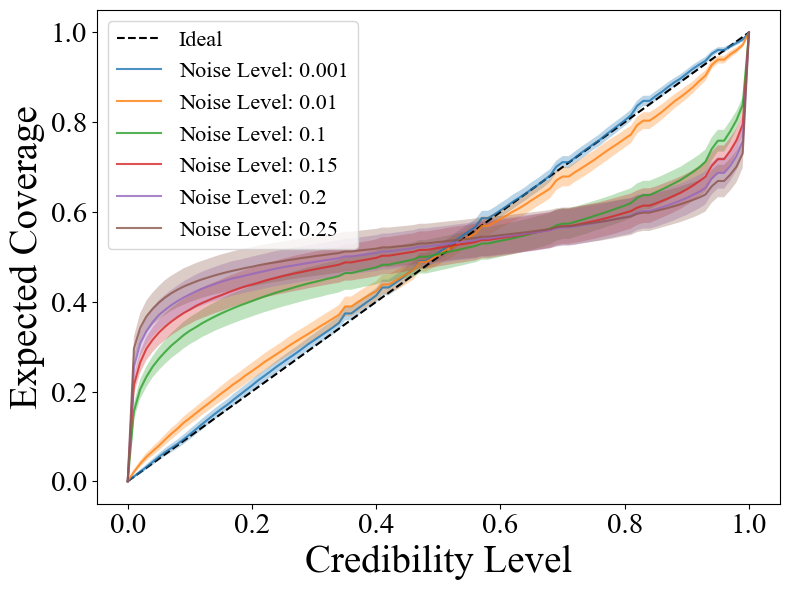

In [26]:
# Run Tarp on LR
# Store TARP-compatible posteriors in a list or dict
from tarp import get_tarp_coverage

plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--', label='Ideal')
k_sigma = [1]
all_ecp_means = []
all_ecp_stds = []
for i in range(0, len(tarp_posteriors)):
    print(f'Noise Model: {noise_levels[i]}')

    # TARP with bootstrapping
    ecp_boot, alpha = get_tarp_coverage(tarp_posteriors[i].copy(), gt_norm.copy(), bootstrap=True, num_bootstrap=100, norm=True)
    ecp_mean = ecp_boot.mean(axis=0)
    ecp_std = ecp_boot.std(axis=0)
    all_ecp_means.append(ecp_mean)
    all_ecp_stds.append(ecp_std)
    plt.plot(alpha, ecp_mean, label=f'Noise Level: {noise_levels[i]}', alpha=0.8)
    for k in k_sigma:
        plt.fill_between(alpha, ecp_mean - k * ecp_std, ecp_mean + k * ecp_std, alpha=0.3)

all_ecp_means = np.array(all_ecp_means)  # shape (n_noise_levels, n_alpha)
all_ecp_stds = np.array(all_ecp_stds)
np.savez(
    './LR_TARP_Bootstrap_Data/LR_TARP_Bootstrap_Data.npz',
    alpha=alpha,
    noise_levels=noise_levels,
    ecp_means=all_ecp_means,
    ecp_stds=all_ecp_stds
)

# Finalize plot
plt.xlabel("Credibility Level", fontsize=28)
plt.ylabel("Expected Coverage", fontsize=28)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig("./PNG_Plots/LR_TARP_Bootstrap_Plot.png", dpi=300)
plt.savefig("./PDF_Plots/LR_TARP_Bootstrap_Plot.pdf", dpi=300)
plt.show()
